# Исследование данных о пользователях сервиса "..."

## Запросы к базе данных.

Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

    SELECT COUNT(p.id)
    FROM stackoverflow.posts p 
    JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
    WHERE pt.type='Question'
    AND (
        p.score > 300
        OR p.favorites_count >= 100);

Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

    WITH t1 AS (SELECT ROUND(COUNT(p.id), 0) c1,
        DATE_TRUNC('day', p.creation_date)::date d1
    FROM stackoverflow.posts p
    JOIN stackoverflow.post_types pt ON p.post_type_id=pt.id
    WHERE pt.type='Question'
    AND DATE_TRUNC('day', p.creation_date)::date BETWEEN '2008-11-01' AND '2008-11-18'
    GROUP BY d1)

    SELECT ROUND(AVG(c1))
    FROM t1

Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

    SELECT COUNT(DISTINCT b.user_id)
    FROM stackoverflow.badges b
    JOIN stackoverflow.users u ON u.id=b.user_id
    WHERE DATE_TRUNC('day', b.creation_date)=DATE_TRUNC('day', u.creation_date)

Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

    SELECT COUNT(DISTINCT p.id)
    FROM stackoverflow.posts p
    JOIN stackoverflow.users u ON u.id=p.user_id
    JOIN stackoverflow.votes v ON v.post_id=p.id
    WHERE u.display_name='Joel Coehoorn'
    AND v.id IS NOT NULL;

Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

    SELECT *, RANK() OVER(ORDER BY id DESC)
    FROM stackoverflow.vote_types
    ORDER BY id

Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

    SELECT v.user_id, COUNT(v.id)
    FROM stackoverflow.votes v
    JOIN stackoverflow.vote_types vt ON vt.id=v.vote_type_id
    WHERE vt.name='Close'
    GROUP BY v.user_id
    ORDER BY COUNT(v.id) DESC, v.user_id DESC
    LIMIT 10;

Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно.
Отобразите несколько полей:
идентификатор пользователя;
число значков;
место в рейтинге — чем больше значков, тем выше рейтинг.
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

    SELECT b.user_id, COUNT(b.id), DENSE_RANK() OVER(ORDER BY COUNT(b.id) DESC)
    FROM stackoverflow.badges b
    WHERE DATE_TRUNC('day', b.creation_date)::date BETWEEN '2008-11-15' AND '2008-12-15'
    GROUP BY b.user_id
    ORDER BY COUNT(b.id) DESC, b.user_id
    LIMIT 10;

Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:
заголовок поста;
идентификатор пользователя;
число очков поста;
среднее число очков пользователя за пост, округлённое до целого числа.
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

    SELECT p.title, p.user_id, p.score, ROUND(AVG(p.score) OVER(PARTITION BY p.user_id), 0)
    FROM stackoverflow.posts p
    WHERE p.score != 0
    AND p.title != '';

Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

    WITH t1 AS (SELECT b.user_id, COUNT(b.id)
    FROM stackoverflow.badges b
    GROUP BY b.user_id
    HAVING COUNT(b.id) > 1000)

    SELECT p.title
    FROM stackoverflow.posts p
    JOIN t1 ON t1.user_id=p.user_id
    WHERE p.title IS NOT NULL

Напишите запрос, который выгрузит данные о пользователях из Канады (англ. Canada). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
пользователям с числом просмотров меньше 100 — группу 3.
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.

    SELECT u.id, u.views,
        CASE
            WHEN u.views < 100 THEN 3
            WHEN u.views < 350 THEN 2
            ELSE 1
        END
    FROM stackoverflow.users u
    WHERE u.location LIKE ('%Canada%')
    AND u.views != 0;

Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

    WITH t1 AS (SELECT u.id, u.views,
        CASE
            WHEN u.views < 100 THEN 3
            WHEN u.views < 350 THEN 2
            ELSE 1
        END AS category
    FROM stackoverflow.users u
    WHERE u.location LIKE ('%Canada%')
    AND u.views != 0),

    t2 AS (SELECT MAX(views) m
                   FROM t1
                   GROUP BY category)

    SELECT id, views, category
    FROM t1
    JOIN t2 ON t1.views=t2.m
    ORDER BY views DESC, category




Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
номер дня;
число пользователей, зарегистрированных в этот день;
сумму пользователей с накоплением.

    WITH t1 AS (SELECT CAST(DATE_TRUNC('day', u.creation_date) AS date) d,
        COUNT(u.id) c
    FROM stackoverflow.users u
    WHERE CAST(DATE_TRUNC('day', u.creation_date) AS date) BETWEEN '2008-11-01' AND '2008-11-30'
    GROUP BY CAST(DATE_TRUNC('day', u.creation_date) AS date))

    SELECT EXTRACT('day' FROM d), c, SUM(c) OVER(ORDER BY d)
    FROM t1

Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
идентификатор пользователя;
разницу во времени между регистрацией и первым постом.

    SELECT u.id, MIN(p.creation_date-u.creation_date)
    FROM stackoverflow.posts p
    JOIN stackoverflow.users u ON u.id=p.user_id
    GROUP BY u.id

## Запросы через Jupyter Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных

In [1]:
db_config = {
    'user': '...', # имя пользователя
    'pwd': '...', # пароль
    'host': '...',
    'port': 0000, # порт подключения
    'db': '...' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
# напишите запрос
query1 = '''
SELECT DATE_TRUNC('month',creation_date)::date month_date, SUM(views_count) total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month',creation_date)::date
ORDER BY SUM(views_count) DESC
'''

# выполните запрос
df1 = pd.read_sql_query(query1, con=engine)
df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Меньше всего просмотров в летние месяцы (июль, август). Пик просмотров приходится на сентябрь, далее количество просмотров постепенно снижается. Эту ситуацию можно объяснить изменениями деловой активности: в сентябре многие люди выходят из отпусков, студенты и школьники возвращаются к занятиям после каникул. Постепенно. когда пользователи вливаются в учебный и рабочий процесс, активность на форуме становится меньше.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [7]:
# напишите запрос
query2 = '''
SELECT u.display_name, COUNT(DISTINCT u.id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id=u.id
WHERE DATE_TRUNC('day', u.creation_date)::date + INTERVAL'1 months' >= DATE_TRUNC('day', p.creation_date)::date
AND p.post_type_id IN (SELECT id
                FROM stackoverflow.post_types
               WHERE type='Answer')
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name

'''

# выполните запрос
df2 = pd.read_sql_query(query2, con=engine)
df2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [8]:
df2.query('count>1')

,display_name,count
4,Alan,8
7,Brian,15
10,Chris,29
12,Craig,10
14,Dan,21
21,Greg,12
25,Jim,7
26,Joe,9
33,Josh,16
34,Keith,5


Многие пользователи при регистрации указывают только имя. Например, на сайте зарегистрированы по 29 пользователей Matt, Chris (имя одно, а пользователи разные).

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [9]:
# напишите запрос
query3 = '''
WITH t1 AS (
    SELECT DISTINCT u.id
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id=p.user_id
    WHERE DATE_TRUNC('month', u.creation_date)::date = '2008-09-01'
    AND DATE_TRUNC('month', p.creation_date)::date = '2008-12-01'
)

SELECT DATE_TRUNC('month', p.creation_date)::date AS month, COUNT(p.id)
FROM stackoverflow.posts p
JOIN t1 ON t1.id=p.user_id
GROUP BY DATE_TRUNC('month', p.creation_date)::date
ORDER BY DATE_TRUNC('month', p.creation_date)::date DESC

'''

# выполните запрос
df3 = pd.read_sql_query(query3, con=engine)
df3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Есть 32 поста, сделанных в августе, которые создали пользователи, зарегистрировавшиеся в сентябре. Возможно, это связано с часовыми поясами: время создания аккаунта определяется по часовому поясу пользователя, время публикации поста по Гринвичу. В связи с этим могло быть такое, что пост пользователя из Китая или Кореи, который зарегистрировался 1го сентября, сайт учёл 31го августа.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [10]:
# напишите запрос
query4 = '''
SELECT user_id, creation_date, views_count, SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполните запрос
df4 = pd.read_sql_query(query4, con=engine)
df4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [11]:
# напишите запрос
query5 = '''
WITH t1 AS(
    SELECT DISTINCT user_id, COUNT(id)
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
    GROUP BY user_id
    HAVING COUNT(id)>120
    ),

t2 AS (
    SELECT p.user_id, COUNT(p.id) c, DATE_TRUNC('day', creation_date) d
    FROM stackoverflow.posts p
    JOIN t1 ON t1.user_id=p.user_id
    WHERE DATE_TRUNC('month', p.creation_date) = '2008-08-01'
    GROUP BY p.user_id, DATE_TRUNC('day', creation_date)
    HAVING COUNT(p.id)>0
)

SELECT DISTINCT user_id, AVG(c) avg_daily
FROM t2
GROUP BY user_id
ORDER BY AVG(c)

'''

# выполните запрос
df5 = pd.read_sql_query(query5, con=engine)
df5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [12]:
# напишите запрос
query6 = '''
WITH t1 AS (
    SELECT DISTINCT user_id, DATE_TRUNC('day', creation_date) d
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('day', creation_date) >= '2008-12-01'
    AND DATE_TRUNC('day', creation_date) <= '2008-12-07'
),

t2 AS (
    SELECT user_id, COUNT(d) c
    FROM t1
    GROUP BY user_id
)
    
SELECT ROUND(AVG(c), 0)::int result
FROM t2


'''

# выполните запрос
df6 = pd.read_sql_query(query6, con=engine)
df6

,result
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем, пользователь пользовался платформой 2 дня в неделю в начале декабря.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

In [13]:
# напишите запрос
query7 = '''
WITH t1 AS (
    SELECT user_id, creation_date, LAG(DATE_TRUNC('month', creation_date), 2, NULL) OVER(PARTITION BY user_id ORDER BY creation_date) d
    FROM stackoverflow.posts
    ORDER BY user_id, creation_date
)

SELECT user_id, creation_date,
    CASE
        WHEN d='2008-07-01' THEN 'July'
        WHEN d='2008-08-01' THEN 'August'
        WHEN d='2008-09-01' THEN 'September'
        WHEN d='2008-10-01' THEN 'October'
        WHEN d='2008-11-01' THEN 'November'
        WHEN d='2008-12-01' THEN 'December'
    END AS second_last_month
FROM t1
'''

# выполните запрос
df7 = pd.read_sql_query(query7, con=engine)
df7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [14]:
# напишите запрос
query8 = '''
WITH t1 AS (
    SELECT user_id, MIN(DATE_TRUNC('month', creation_date)) cohort_dt
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY cohort_dt
),
profile AS (
    SELECT user_id,
        cohort_dt,
        COUNT(*) OVER (PARTITION BY cohort_dt) cohort_users_cnt
    FROM t1
 ),
sessions AS (
    SELECT user_id,
        DATE_TRUNC('month', creation_date) session_date
        FROM stackoverflow.posts
        GROUP BY 1,2
)

SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id)*100.0/p.cohort_users_cnt, 2) retention_rate
FROM profile p
JOIN sessions s ON p.user_id=s.user_id
GROUP BY 1, 2, 4
ORDER BY 1, 2

'''

# выполните запрос
df8 = pd.read_sql_query(query8, con=engine)
df8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

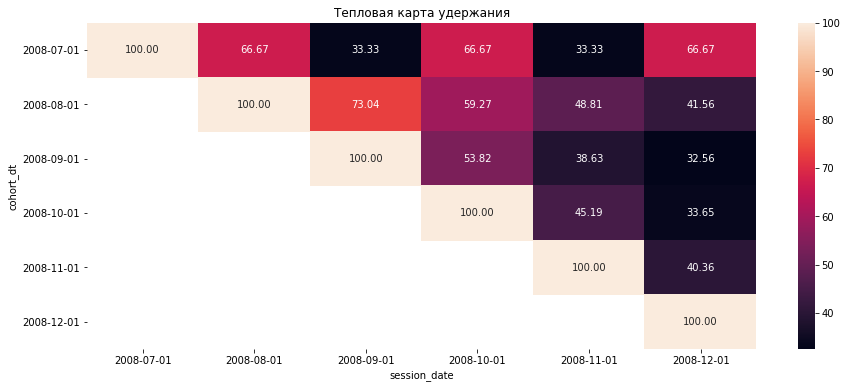

In [15]:
df8['cohort_dt']=df8['cohort_dt'].astype('str')
df8['session_date']=df8['session_date'].astype('str')
df8_=df8.pivot_table(index='cohort_dt', columns='session_date', values='retention_rate')
plt.figure(figsize=(15, 6))
sns.heatmap(df8_, annot=True, fmt='.2f')
plt.title('Тепловая карта удержания')
plt.show()

Аномально выглядит июльская когорта, но в ней всего лишь 3 пользователя (из-за слишком маленькой выборки мы не наблюдаем постепенное снижение Retention Rate).
Лучшие показатели удержания демонстрируют пользователи из августовской когорты. Когорты, начиная с сентября, включают в себя больше пользователей, но Retention Rate ниже. Как говорили выше, возможно, что, начиная с сентября, на сайт заходили студенты и школьники после каникул, чтобы найти нужную информацию, и, получив её, многие из них дальнейшее участие в работе сообщества на сайте не принимали.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [16]:
# напишите запрос
query9 = '''
WITH t1 AS (
    SELECT EXTRACT('month' FROM creation_date)::int creation_month,
        COUNT(id) posts_count
    FROM stackoverflow.posts
    WHERE DATE_TRUNC('day', creation_date) BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY EXTRACT('month' FROM creation_date)
)

SELECT *, ROUND((posts_count - LAG(posts_count, 1, NULL) OVER())::numeric / LAG(posts_count, 1, NULL) OVER() *100, 2) percentage
FROM t1

'''

# выполните запрос
df9 = pd.read_sql_query(query9, con=engine)
df9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

Text(0.5, 1.0, 'Количество постов по месяцам')

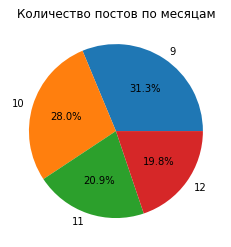

In [17]:
# постройте круговую диаграмму с количеством постов по месяцам
plt.pie(df9['posts_count'], labels=df9['creation_month'], autopct='%1.1f%%')
plt.title('Количество постов по месяцам')

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [18]:
# напишите запрос
query10 = '''
WITH t1 AS (
    SELECT user_id, COUNT(id)
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT(id) DESC
    LIMIT 1
)
SELECT DISTINCT EXTRACT('week' FROM p.creation_date)::int week_creation,
    MAX(p.creation_date) OVER (PARTITION BY EXTRACT('week' FROM p.creation_date)) creation_date
FROM stackoverflow.posts p
JOIN t1 ON t1.user_id=p.user_id
WHERE DATE_TRUNC('month', p.creation_date)='2008-10-01'

'''

# выполните запрос
df10 = pd.read_sql_query(query10, con=engine)
df10

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
